In [2]:
# Importing necessary libraries for data analysis and modeling
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import ConfusionMatrixDisplay

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Loading the dataset
# Since the original file has no headers, we use 'header=None' and define column names manually.
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df = pd.read_csv("car_evaluation.csv", header=None, names=col_names)

# Checking the dataset structure
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (1728, 7)


,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [13]:
df.describe()

,buying,maint,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


In [3]:
# Separating features (X) and target variable (y)
X = df.drop('class', axis=1)
y = df['class']

# Splitting the data into training (70%) and testing (30%) sets
# random_state=42 ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training Set Shape: {X_train.shape}")
print(f"Testing Set Shape:  {X_test.shape}")

Training Set Shape: (1209, 6)
Testing Set Shape:  (519, 6)


In [4]:
# Setting up the Pipeline
# Step 1: OrdinalEncoder -> Converts categorical features (e.g., 'low', 'high') into numbers.
# Step 2: DecisionTreeClassifier -> The machine learning model.
pipe = Pipeline([
    ('encoder', OrdinalEncoder()),
    ('model', DecisionTreeClassifier())
])

# Defining the Hyperparameter Grid for optimization
# limiting max_depth helps prevent overfitting
param_grid = {
    'model__max_depth': range(3, 10),        # Test depths from 3 to 9
    'model__criterion': ['gini', 'entropy'], # Splitting criteria
    'model__min_samples_leaf': [1, 5, 10]    # Minimum samples required at a leaf node
}

# Initializing GridSearchCV to find the best model parameters
# cv=5 means 5-fold Cross-Validation
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Training completed!")

Optimizing model parameters, please wait...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for 

Training completed!


In [5]:
# Displaying the best parameters found by GridSearch
print(f"Best Parameters: {grid.best_params_}")
print(f"Best Cross-Validation Score: {grid.best_score_:.4f}")

# Evaluating performance on the unseen Test Set
best_model_accuracy = grid.score(X_test, y_test)
print(f"Test Set Accuracy: {best_model_accuracy:.4f}")

# Extracting the best decision tree model from the pipeline for further analysis
best_tree = grid.best_estimator_.named_steps['model']

Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': 9, 'model__min_samples_leaf': 1}
Best Cross-Validation Score: 0.9636
Test Set Accuracy: 0.9422


<Figure size 1000x600 with 0 Axes>

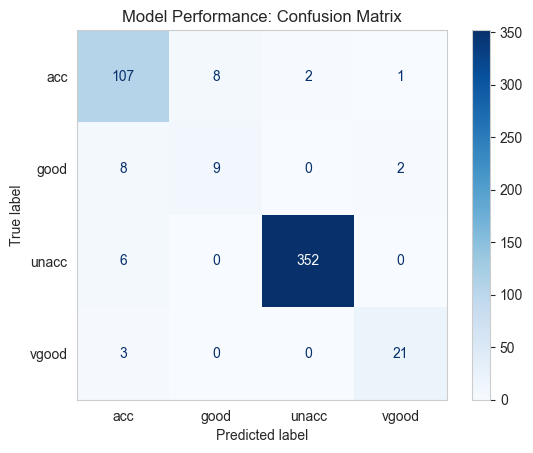

In [6]:
# Generating predictions on the test set
y_pred = grid.predict(X_test)

# Plotting the Confusion Matrix
plt.figure(figsize=(10, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Model Performance: Confusion Matrix")
plt.grid(False) # Turn off grid lines for better visibility
plt.savefig("confusion_matrix.png", dpi=300) # Save for README
plt.show()

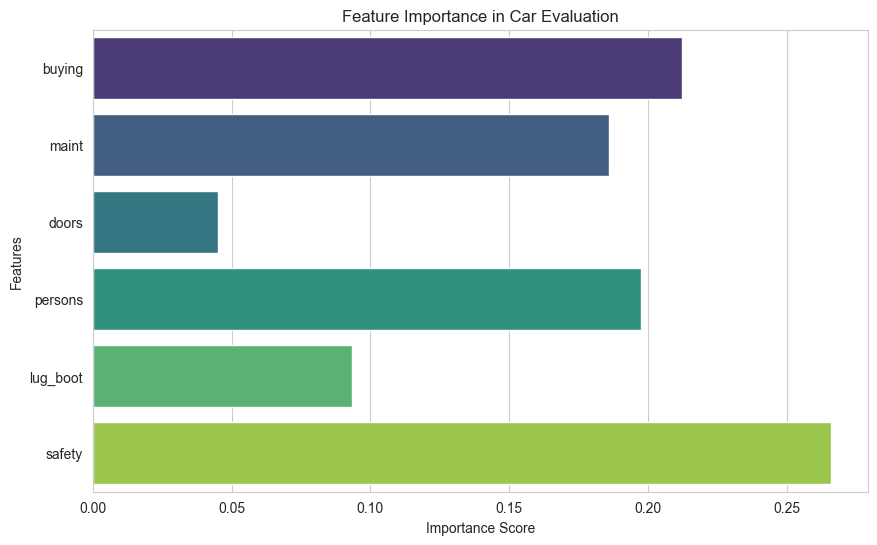

In [7]:
# Getting feature importance scores from the trained tree
importances = best_tree.feature_importances_
feature_names = X.columns

# Visualizing feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names, palette="viridis")
plt.title("Feature Importance in Car Evaluation")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.savefig("feature_importance.png", dpi=300)
plt.show()

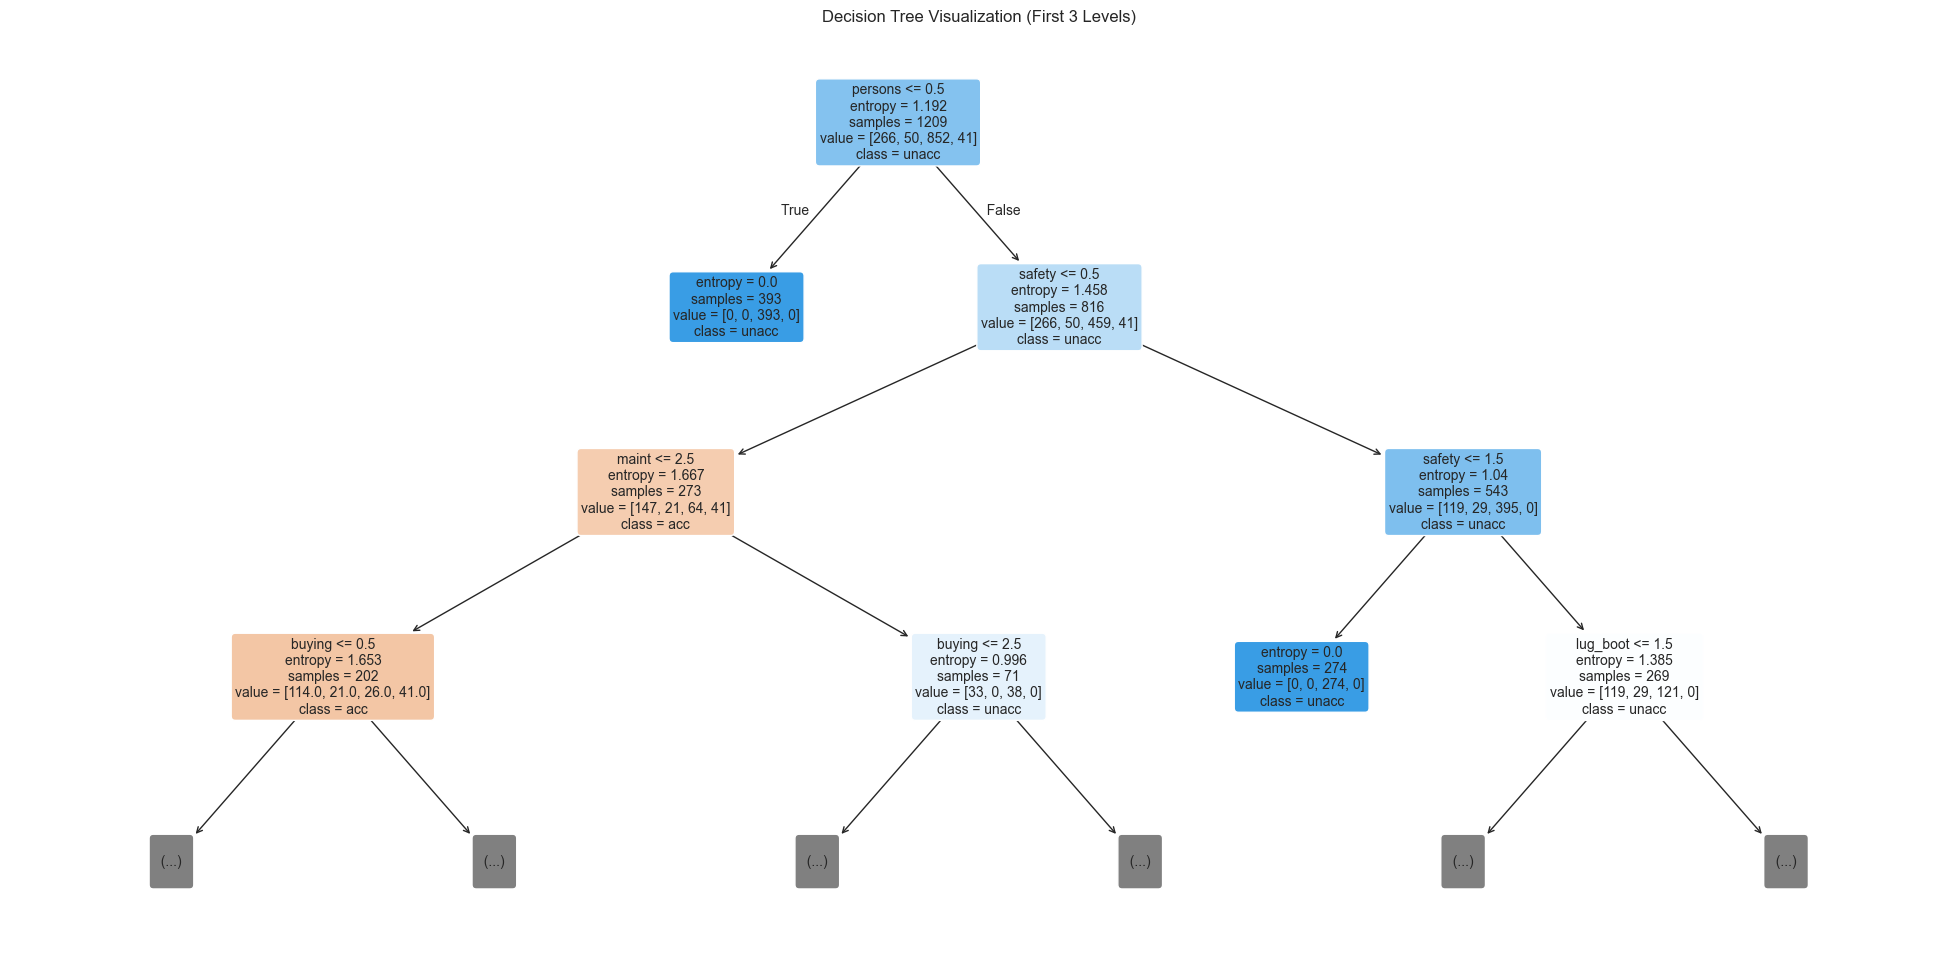

In [8]:
# Visualizing the Decision Tree logic (First 3 levels)
plt.figure(figsize=(25, 12))
plot_tree(best_tree,
          feature_names=X.columns,
          class_names=best_tree.classes_,
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=3) # Limiting depth for readability
plt.title("Decision Tree Visualization (First 3 Levels)")
plt.savefig("decision_tree_viz.png", dpi=300)
plt.show()